In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import ruamel.yaml as yaml
import torch
import scipy.stats as stats

from soul_gan.datasets.utils import get_dataset, prepare_2d_gaussian_grid_data, prepare_2d_ring_data

from soul_gan.utils.general_utils import DotConfig, CONFIGS_DIR, DATA_DIR
from soul_gan.models.utils import GANWrapper

In [2]:
config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/grid-js-mlp.yml').open('r'))).gan_config

mean = np.array(config.train_transform.Normalize.mean)
std = np.array(config.train_transform.Normalize.std)

In [3]:
mean, std

(array([0., 0.]), array([1.415, 1.415]))

In [4]:
sigma = 0.05
n_modes = 25
sample, modes = prepare_2d_gaussian_grid_data(int(5e3), sigma=sigma, n_modes=n_modes)

dists = np.linalg.norm(modes[:, None] - modes[None, :], ord=2, axis=-1)
dists += dists.max() * np.eye(dists.shape[0])
eps = dists.min(-1)

np.savez(
    Path(DATA_DIR, f'{n_modes}_gaussians_modes.npz').open('wb'), 
    centroids=(modes - mean[None, :]) / std[None, :], 
    closest_pts=(modes - mean[None, :]) / std[None, :], 
    sigmas=np.ones(len(modes))*sigma / std[0],
    priors=np.ones(len(modes)) / len(modes),
    eps=eps)


In [5]:
kind = 'grid'

dataset = get_dataset(f"gaussians_{kind}", int(5e3))
dataset[0]

tensor([-2.0021, -0.9231])

In [6]:
kind = ''

In [7]:
def plot(target, feature, step_size, suffix='', step=1000):
    path = Path(f'../log/{feature}_{target}Target/mlp_{kind}{suffix}_{step_size}')
    xs = np.load(Path(path, f'images/{step}.npy'))

    plt.figure(figsize=(5, 5))
    plt.scatter(xs[:, 0], xs[:, 1], alpha=0.1, s=10)

    plt.scatter(modes[:, 0], modes[:, 1], color='r', marker='x')
    
    plt.axis('equal')
    plt.grid()

    Path(path, 'figs').mkdir(exist_ok=True)
    plt.savefig(Path(path, f'figs/{kind}{suffix}_{step_size}_2d_{step}.png'))

## Wasserstein GAN

In [8]:
suffix = 'wass'

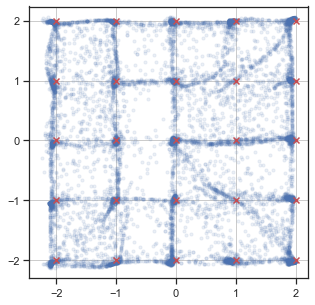

In [9]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=0, suffix=suffix)

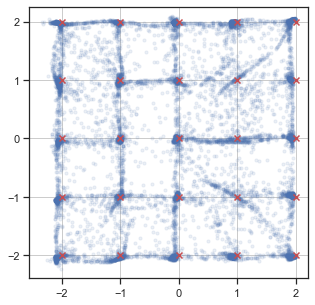

In [10]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)

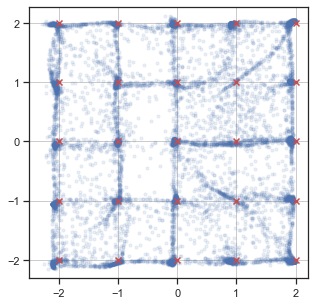

In [11]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)


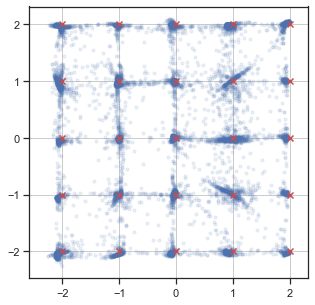

In [12]:
step_size = 0.001
target = 'Discriminator'
feature = 'discriminator_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)


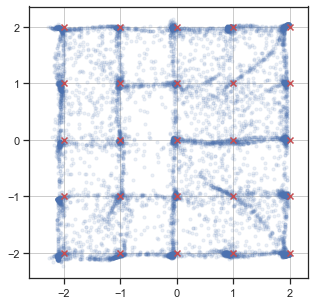

In [13]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v1')

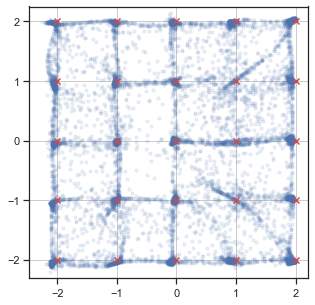

In [14]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v2')

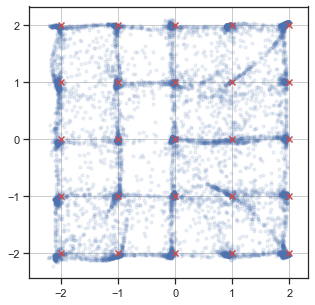

In [15]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v3')

In [16]:
# target = 'Prior'
# feature = 'cluster_feature'

# plot(target, feature, step_size, step=1000, suffix=suffix)

In [17]:
device = torch.device(0)

config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/grid-wass-mlp.yml').open('r'))).gan_config
gan = GANWrapper(config, device)
gen, dis = gan.gen, gan.dis

In [18]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-2.5, 2.5, n_pts_ax), np.linspace(-2.5, 2.5, n_pts_ax))

zs = gen.prior.sample((n_kde_pts,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()
dgz = dis(xs_normalized).squeeze().detach().cpu().numpy()

reals = torch.from_numpy(np.stack(real_grid, -1).reshape(-1, 2)).to(device).float()
dgz_ = dis(dis.transform(reals)).squeeze()

reals_np = reals.detach().cpu().numpy()

In [19]:
dgz_.mean(), dgz.mean()

(tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>), 1.1231486)

In [20]:
dis(dis.transform(torch.as_tensor(sample).to(device))).mean()

tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)

In [21]:
kde = stats.kde.gaussian_kde(xs.transpose(1, 0))
log_probs = kde.logpdf(reals_np.transpose(1, 0))

Text(0.5, 1.0, '$-\\hat{E}(x) = \\log p_G(x) + d(x)$')

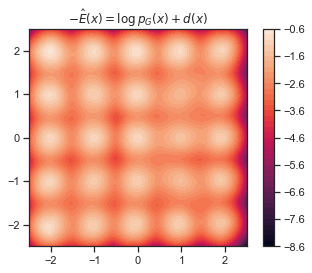

In [22]:
energy = (log_probs + dgz_.detach().cpu().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)
#Path('../figs/100gaussians').mkdir(exist_ok=True)

xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
#plt.savefig(Path('../figs/100gaussians', 'minus_energy_sigma_0.025.png'))

Text(0.5, 1.0, '$\\log p_G(x)$')

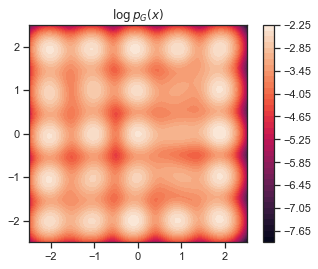

In [23]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
# plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

Text(0.5, 1.0, '$d(x)$')

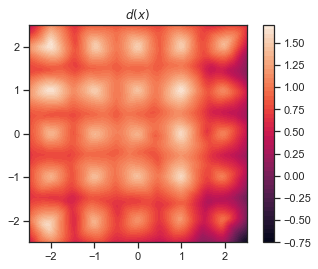

In [24]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().cpu().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
# plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

Text(0.5, 1.0, 'Points produced by Generator')

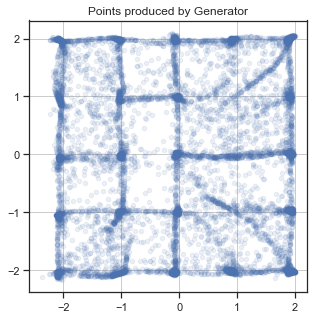

In [25]:
zs = gen.prior.sample((10000,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(xs[:, 0], xs[:, 1], s=20, alpha=0.1)
ax.set_aspect('equal')
plt.grid()
plt.title('Points produced by Generator')
# plt.savefig(Path('../figs/100gaussians', 'gen_0.025.png'))

## Jensen-Shannon GAN

In [26]:
suffix = 'js'

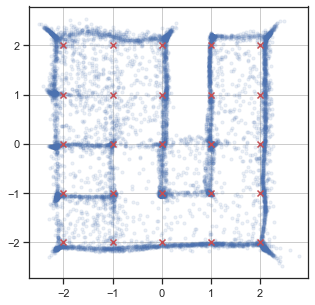

In [27]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=0, suffix=suffix)

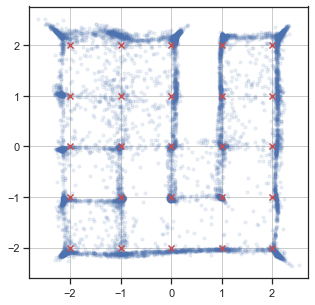

In [28]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)

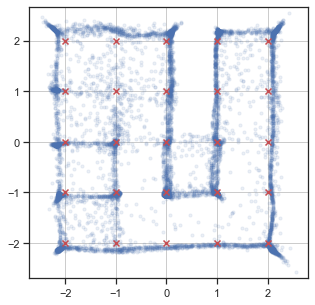

In [29]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)

In [30]:
# target = 'Prior'
# feature = 'cluster_feature'

# plot(target, feature, step_size, step=1000, suffix=suffix)

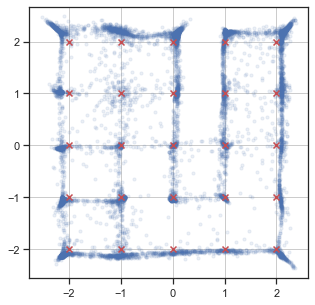

In [31]:
step_size = 0.001
target = 'Discriminator'
feature = 'discriminator_feature'

plot(target, feature, step_size, step=1000, suffix=suffix)

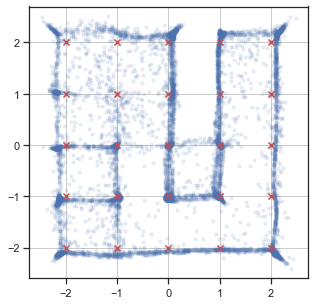

In [32]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v1')

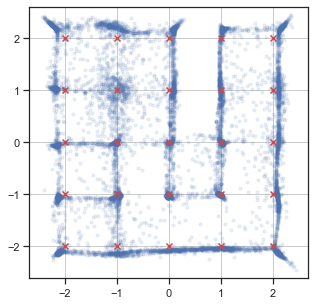

In [33]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v2')

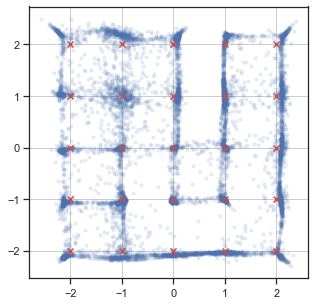

In [34]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, step=1000, suffix=suffix+'_v3')

In [35]:
device = torch.device(0)

config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/grid-js-mlp.yml').open('r'))).gan_config
gan = GANWrapper(config, device)
gen, dis = gan.gen, gan.dis

In [36]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-2.5, 2.5, n_pts_ax), np.linspace(-2.5, 2.5, n_pts_ax))

zs = gen.prior.sample((n_kde_pts,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()
dgz = dis(xs_normalized).squeeze().detach().cpu().numpy()

reals = torch.from_numpy(np.stack(real_grid, -1).reshape(-1, 2)).to(device).float()
dgz_ = dis(dis.transform(reals)).squeeze()

reals_np = reals.detach().cpu().numpy()

In [37]:
dgz_.mean(), dgz.mean()

(tensor(-0.4086, device='cuda:0', grad_fn=<MeanBackward0>), -0.041902337)

In [38]:
kde = stats.kde.gaussian_kde(xs.transpose(1, 0))
log_probs = kde.logpdf(reals_np.transpose(1, 0))

Text(0.5, 1.0, '$-\\hat{E}(x) = \\log p_G(x) + d(x)$')

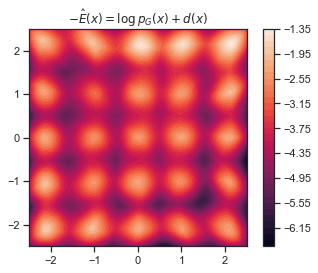

In [39]:
energy = (log_probs + dgz_.detach().cpu().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)

xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')

Text(0.5, 1.0, '$\\log p_G(x)$')

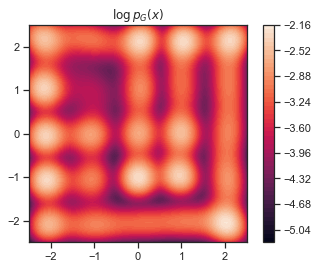

In [40]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
# plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

Text(0.5, 1.0, '$d(x)$')

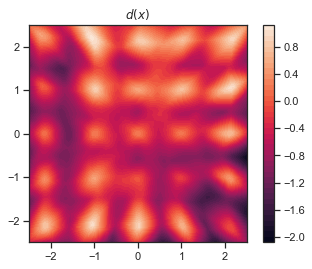

In [41]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().cpu().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
# plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

Text(0.5, 1.0, 'Points produced by Generator')

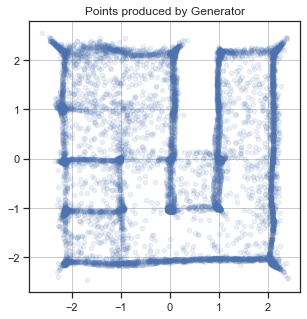

In [42]:
zs = gen.prior.sample((10000,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(xs[:, 0], xs[:, 1], s=20, alpha=0.1)
ax.set_aspect('equal')
plt.grid()
plt.title('Points produced by Generator')
# plt.savefig(Path('../figs/100gaussians', 'gen_0.025.png'))